# Installations that cause frequent errors on TPU

In [1]:
!pip install seaborn
!pip install imbalanced-learn


[notice] A new release of pip is available: 23.0.1 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.1
[notice] To update, run: pip install --upgrade pip


# Set Environment

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

D0624 19:42:29.660143953    5981 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0624 19:42:29.660168832    5981 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0624 19:42:29.660171971    5981 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0624 19:42:29.660174371    5981 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0624 19:42:29.660176765    5981 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0624 19:42:29.660178980    5981 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0624 19:42:29.660181266    5981 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0624 19:42:29.

TensorFlow version: 2.12.0


# Set Seed for Reproducibility

In [3]:
def set_seed(seed=21019):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Load Data

In [4]:
import pickle
from tensorflow.keras.utils import to_categorical


# Define class names
class_names = ['Unidentifiable', 'Type 1', 'Type 2', 'Type 3']

# Load data splits using pickle
print('Loading data splits ...')
with open('/kaggle/input/create-folds/folds.pkl', 'rb') as f:
    folds = pickle.load(f)

# Extract the splits
X1, X2, X3, X4, X5 = folds['X1'], folds['X2'], folds['X3'], folds['X4'], folds['X5']
y1, y2, y3, y4, y5 = folds['y1'], folds['y2'], folds['y3'], folds['y4'], folds['y5']

# Define the input shape (assuming all splits have the same input shape)
input_shape = X1[0].shape

# Number of classes
num_classes = len(class_names)

# Image size
image_size = (256, 256)

# Apply one-hot encoding to the labels
y1_encoded = to_categorical(y1, num_classes=num_classes)
y2_encoded = to_categorical(y2, num_classes=num_classes)
y3_encoded = to_categorical(y3, num_classes=num_classes)
y4_encoded = to_categorical(y4, num_classes=num_classes)
y5_encoded = to_categorical(y5, num_classes=num_classes)

print("Data splits loaded and one-hot encoded successfully.")

# Print summary of splits
splits = [(X1, y1_encoded), (X2, y2_encoded), (X3, y3_encoded), (X4, y4_encoded), (X5, y5_encoded)]
for i, (X_split, y_split) in enumerate(splits, start=1):
    print(f"Split {i}:")
    print(f"  X shape: {X_split.shape}")
    print(f"  y shape: {y_split.shape}")
    class_counts = np.bincount(np.argmax(y_split, axis=1))
    for class_idx, count in enumerate(class_counts):
        print(f'  Class {class_names[class_idx]}: {count} samples')

Loading data splits ...
Data splits loaded and one-hot encoded successfully.
Split 1:
  X shape: (1623, 256, 256, 3)
  y shape: (1623, 4)
  Class Unidentifiable: 569 samples
  Class Type 1: 218 samples
  Class Type 2: 565 samples
  Class Type 3: 271 samples
Split 2:
  X shape: (1623, 256, 256, 3)
  y shape: (1623, 4)
  Class Unidentifiable: 569 samples
  Class Type 1: 218 samples
  Class Type 2: 565 samples
  Class Type 3: 271 samples
Split 3:
  X shape: (1621, 256, 256, 3)
  y shape: (1621, 4)
  Class Unidentifiable: 569 samples
  Class Type 1: 217 samples
  Class Type 2: 564 samples
  Class Type 3: 271 samples
Split 4:
  X shape: (1621, 256, 256, 3)
  y shape: (1621, 4)
  Class Unidentifiable: 569 samples
  Class Type 1: 217 samples
  Class Type 2: 564 samples
  Class Type 3: 271 samples
Split 5:
  X shape: (1620, 256, 256, 3)
  y shape: (1620, 4)
  Class Unidentifiable: 569 samples
  Class Type 1: 217 samples
  Class Type 2: 564 samples
  Class Type 3: 270 samples


# Train-Validation-Test Set

In [5]:
from sklearn.model_selection import train_test_split


set_seed()

# Concatenate X2 to X5 into x_train and y2 to y5 into y_train
x_train = np.concatenate((X4, X3, X2, X1), axis=0)
y_train = np.concatenate((y4_encoded, y3_encoded, y2_encoded, y1_encoded), axis=0)

# Set X1 as x_test and y1 as y_test
x_test = X5
y_test = y5_encoded

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Detect TPU

In [6]:
# Detect and initialize the TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

# Oversampling

In [7]:
import gc
from imblearn.over_sampling import SMOTE
from collections import Counter


set_seed()

# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()
    
# Initialize SMOTE
smote = SMOTE(random_state=2119)

# Reshape the data for oversampling
X_reshaped = x_train.reshape(-1, image_size[0] * image_size[1] * 3)

# Apply oversampling
X_resampled, y_resampled = smote.fit_resample(X_reshaped, np.argmax(y_train, axis=1))

print("Shape of X_resampled:", X_resampled.shape)
print("Shape of y_resampled:", y_resampled.shape)

# Reshape the data back to the original shape
X_resampled = X_resampled.reshape(-1, image_size[0], image_size[1], 3)

x_train = X_resampled
y_train = to_categorical(y_resampled, num_classes=num_classes)
    
del X_resampled
del y_resampled

# Calculate class distribution after oversampling
resampled_class_distribution = Counter(np.argmax(y_train, axis=1).tolist())
print("Class distribution after oversampling:", resampled_class_distribution)

print(f'Total Number of Samples after Oversampling: {len(y_train)+len(y_val)+len(y_test)}')
print(f'Samples in Train Set: {len(y_train)}')
print(f'Samples in Validation Set: {len(y_val)}')
print(f'Samples in Test Set: {len(y_test)}')

Freeing up memory!
Shape of X_resampled: (7360, 196608)
Shape of y_resampled: (7360,)
Class distribution after oversampling: Counter({2: 1840, 0: 1840, 1: 1840, 3: 1840})
Total Number of Samples after Oversampling: 10278
Samples in Train Set: 7360
Samples in Validation Set: 1298
Samples in Test Set: 1620


# Augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter


# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=90,  # Rotate images randomly between -90 and 90 degrees
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True  # Randomly flip images vertically
)

set_seed()

# Define the proportion of data to augment
augmentation_proportion = 0.8  # For example, augment 50% of the data

# Determine the number of samples to augment
num_samples_to_augment = int(len(x_train) * augmentation_proportion)

# Randomly select samples to augment
indices_to_augment = np.random.choice(len(x_train), num_samples_to_augment, replace=False)

# Augment the selected samples
x_augmented = []
y_augmented = []
for idx in indices_to_augment:
    image = x_train[idx]
    label = y_train[idx]
    # Apply augmentation
    augmented_images = datagen.flow(np.expand_dims(image, axis=0), np.expand_dims(label, axis=0), batch_size=1)
    for _ in range(2):  # Augment each sample twice
        augmented_image, augmented_label = next(augmented_images)
        x_augmented.append(augmented_image.squeeze())
        y_augmented.append(augmented_label.squeeze())

# Convert lists to arrays
x_augmented = np.array(x_augmented)
y_augmented = np.array(y_augmented)

# Concatenate augmented data with original data
x_train_augmented = np.concatenate([x_train, x_augmented])
y_train_augmented = np.concatenate([y_train, y_augmented])

# Print statements
print(f"Original x_train shape: {x_train.shape}")
print(f"Original y_train shape: {y_train.shape}")

print(f"Number of samples to augment: {num_samples_to_augment}")
print(f"x_augmented shape: {x_augmented.shape}")
print(f"y_augmented shape: {y_augmented.shape}")

print(f"Augmented x_train shape: {x_train_augmented.shape}")
print(f"Augmented y_train shape: {y_train_augmented.shape}")

# Verify class distribution in augmented data
augmented_class_distribution = Counter(np.argmax(y_train_augmented, axis=1).tolist())
print("Class distribution after augmentation:", augmented_class_distribution)

Original x_train shape: (7360, 256, 256, 3)
Original y_train shape: (7360, 4)
Number of samples to augment: 5888
x_augmented shape: (11776, 256, 256, 3)
y_augmented shape: (11776, 4)
Augmented x_train shape: (19136, 256, 256, 3)
Augmented y_train shape: (19136, 4)
Class distribution after augmentation: Counter({1: 4806, 2: 4796, 3: 4772, 0: 4762})


# Create Model

In [9]:
from tensorflow.keras import layers, models, regularizers, initializers, Input
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D, Dense, Dropout, Conv2D, Average
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# Define the kernel initializer and L2 regularization strength
initializer = initializers.he_normal()
regularizer = regularizers.l2(0.05)
attention_features = 256

# Define the attention block
def attention_block(in_features_l, in_features_g, attn_features):
    W_l = Conv2D(filters=attn_features, kernel_size=1, padding='same', use_bias=False)(in_features_l)
    W_g = Conv2D(filters=attn_features, kernel_size=1, padding='same', use_bias=False)(in_features_g)

    H, W = in_features_l.shape[1], in_features_l.shape[2]
    W_g = tf.image.resize(W_g, (W, H), method=tf.image.ResizeMethod.BILINEAR)

    sum_feature_maps = W_l + W_g
    sum_relu = Activation('relu')(sum_feature_maps)
    sum_conv = Conv2D(filters=1, kernel_size=1, padding='same', use_bias=True)(sum_relu)
    sum_softmax = Activation('softmax')(sum_conv)

    result_feature_map = tf.multiply(sum_softmax, in_features_l)
    return sum_softmax, result_feature_map

# Create the model within the TPU strategy scope
with strategy.scope():
    inputs = Input(shape=input_shape)

    # ResNet50 base model
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    resnet_base.trainable = True

    res_conv_block1 = resnet_base.get_layer('conv5_block1_out').output
    res_conv_block2 = resnet_base.get_layer('conv5_block2_out').output
    res_conv_block3 = resnet_base.get_layer('conv5_block3_out').output

    res_attn1, res_attnoutput1 = attention_block(res_conv_block1, res_conv_block3, attention_features)
    res_attn2, res_attnoutput2 = attention_block(res_conv_block2, res_conv_block3, attention_features)

    res_pool = GlobalAveragePooling2D()
    rg = res_pool(res_conv_block3)
    rg1 = res_pool(res_attnoutput1)
    rg2 = res_pool(res_attnoutput2)

    rg_hat = tf.concat([rg, rg1, rg2], axis=1)

    # InceptionV3 base model
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)
    inception_base.trainable = True

    in_conv_block1 = inception_base.get_layer('mixed7').output
    in_conv_block2 = inception_base.get_layer('mixed8').output
    in_conv_block3 = inception_base.get_layer('mixed9').output
    in_conv_block4 = inception_base.get_layer('mixed10').output

    in_attn1, in_attnoutput1 = attention_block(in_conv_block1, in_conv_block4, attention_features)
    in_attn2, in_attnoutput2 = attention_block(in_conv_block2, in_conv_block4, attention_features)
    in_attn3, in_attnoutput3 = attention_block(in_conv_block3, in_conv_block4, attention_features)

    ig = res_pool(in_conv_block4)
    ig1 = res_pool(in_attnoutput1)
    ig2 = res_pool(in_attnoutput2)
    ig3 = res_pool(in_attnoutput3)

    ig_hat = tf.concat([ig, ig1, ig2, ig3], axis=1)

    x = Average()([rg_hat, ig_hat])
    outputs = Dense(512, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)


    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Train Model

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import load_model


set_seed()
        
# Create the Learning Rate callback
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-10)
    
# Create a ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint_callback = ModelCheckpoint(f'best_model.h5',
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True,
                                      save_weights_only=True)
    
# Define the early stopping callback to stop training if validation loss does not improve
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)


# Train the model with history tapping (keeps data in a dictionary)
epochs = 40
batch_size = 64
history = model.fit(x_train_augmented, y_train_augmented,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[lr_callback, checkpoint_callback, early_stopping_callback],
                    shuffle=True)

# Save the best model
model.save('best_model.h5')

# Load the saved best model
best_model = load_model('best_model.h5')

# Evaluate the model on the test set
results = best_model.evaluate(x_test, y_test)
print(f'\033[1mTest Accuracy = {results[1]:.4f}\033[0m')

# Predict on the test set and calculate precision, recall, and f1 score
y_pred = best_model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)

precision, recall, f1, _ = precision_recall_fscore_support(y_test_class, y_pred_class, average='macro')

print(f'\033[1mTest Precision = {precision:.4f}\033[0m')
print(f'\033[1mTest Recall = {recall:.4f}\033[0m')
print(f'\033[1mTest F1 Score = {f1:.4f}\033[0m')

Epoch 1/40


2024-06-24 19:47:29.692348: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-06-24 19:47:31.504253: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


299/299 [==============================] - ETA: 0s - loss: 1.2196 - accuracy: 0.6317

2024-06-24 19:49:25.552682: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-06-24 19:49:25.939767: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


299/299 [==============================] - 202s 249ms/step - loss: 1.2196 - accuracy: 0.6317 - val_loss: 1.0647 - val_accuracy: 0.7080 - lr: 1.0000e-04
Epoch 2/40
299/299 [==============================] - 35s 118ms/step - loss: 0.8190 - accuracy: 0.7868 - val_loss: 1.0028 - val_accuracy: 0.7203 - lr: 1.0000e-04
Epoch 3/40
299/299 [==============================] - 36s 119ms/step - loss: 0.5264 - accuracy: 0.8871 - val_loss: 0.9547 - val_accuracy: 0.7427 - lr: 1.0000e-04
Epoch 4/40
299/299 [==============================] - 36s 119ms/step - loss: 0.3522 - accuracy: 0.9332 - val_loss: 0.9215 - val_accuracy: 0.7558 - lr: 1.0000e-04
Epoch 5/40
299/299 [==============================] - 33s 110ms/step - loss: 0.2540 - accuracy: 0.9564 - val_loss: 1.0220 - val_accuracy: 0.7550 - lr: 1.0000e-04
Epoch 6/40
299/299 [==============================] - 36s 119ms/step - loss: 0.1861 - accuracy: 0.9716 - val_loss: 0.8665 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 7/40
299/299 [==================

# Confusion Matrix

51/51 [==============================] - 54s 1s/step


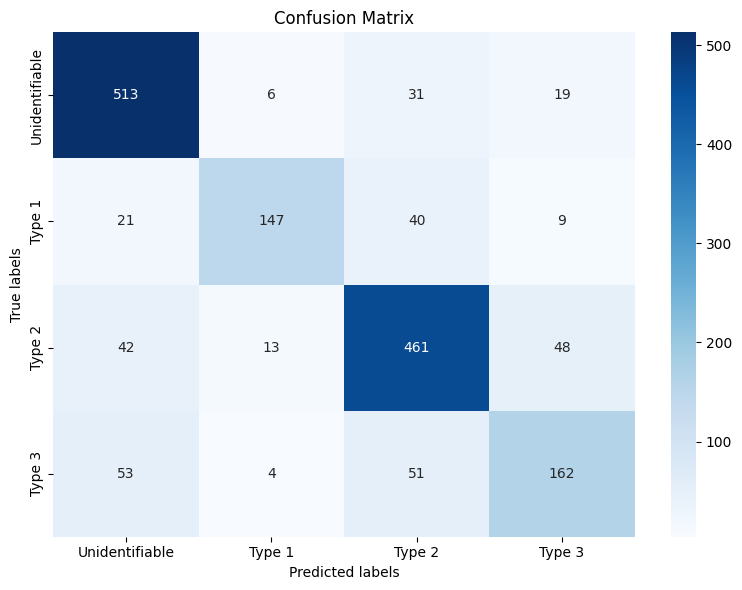

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Predict on the test set
y_pred = best_model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.tight_layout()

# Save the plot as an image
plt.savefig('confusion_matrix.png', dpi=600)

# Display the plot
plt.show()

# Training Curves

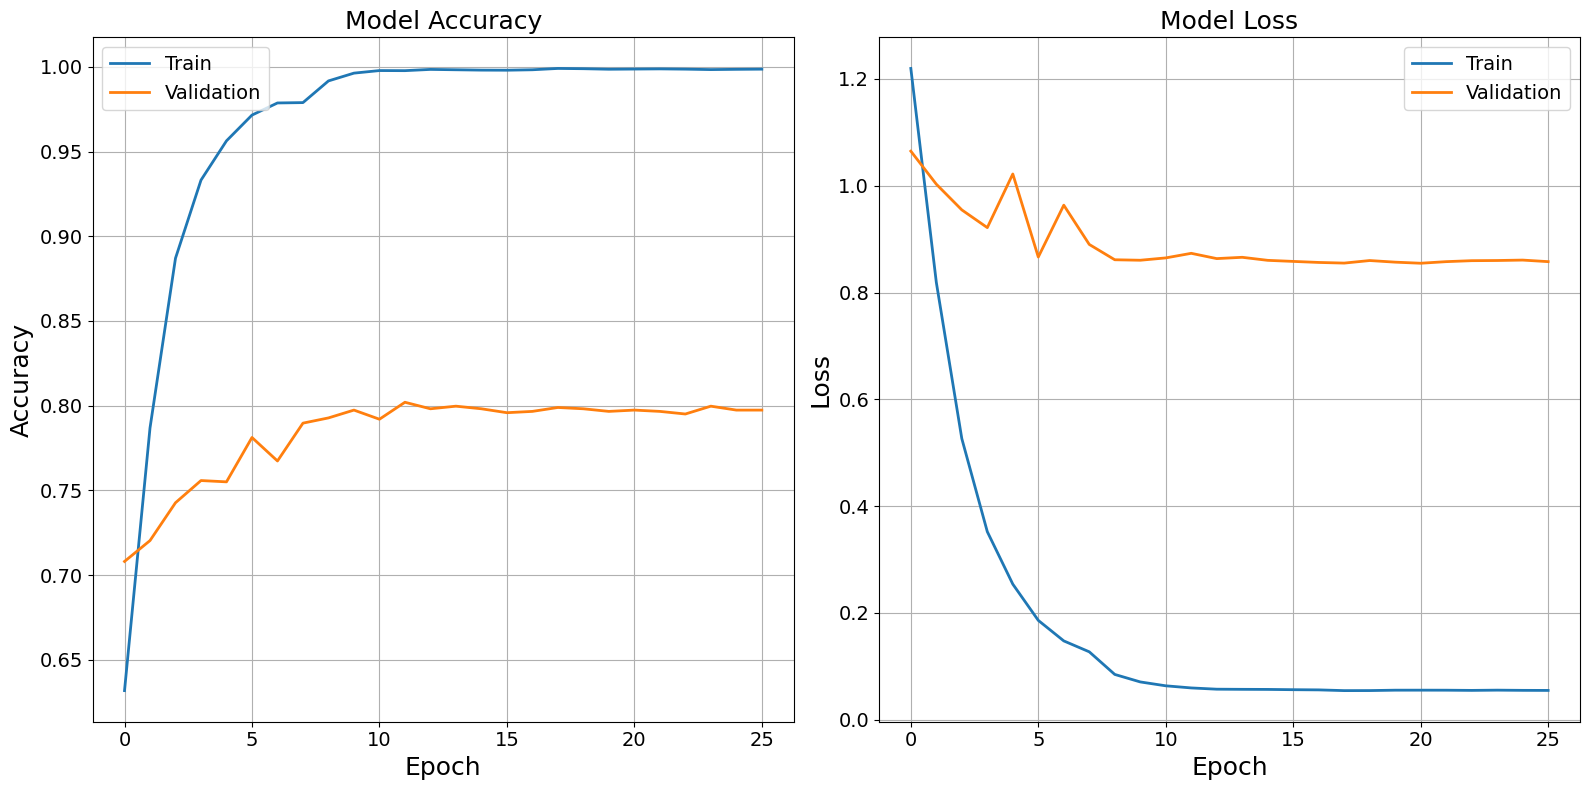

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], linewidth=2)
plt.plot(history.history['val_accuracy'], linewidth=2)
plt.title('Model Accuracy', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=14)
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], linewidth=2)
plt.plot(history.history['val_loss'], linewidth=2)
plt.title('Model Loss', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=14)
plt.grid(True)

# Save the plot as a high-resolution image
plt.tight_layout()
plt.savefig('training_curves.png', dpi=600)

# Show the plot
plt.show()

# AU-ROC

51/51 [==============================] - 55s 1s/step


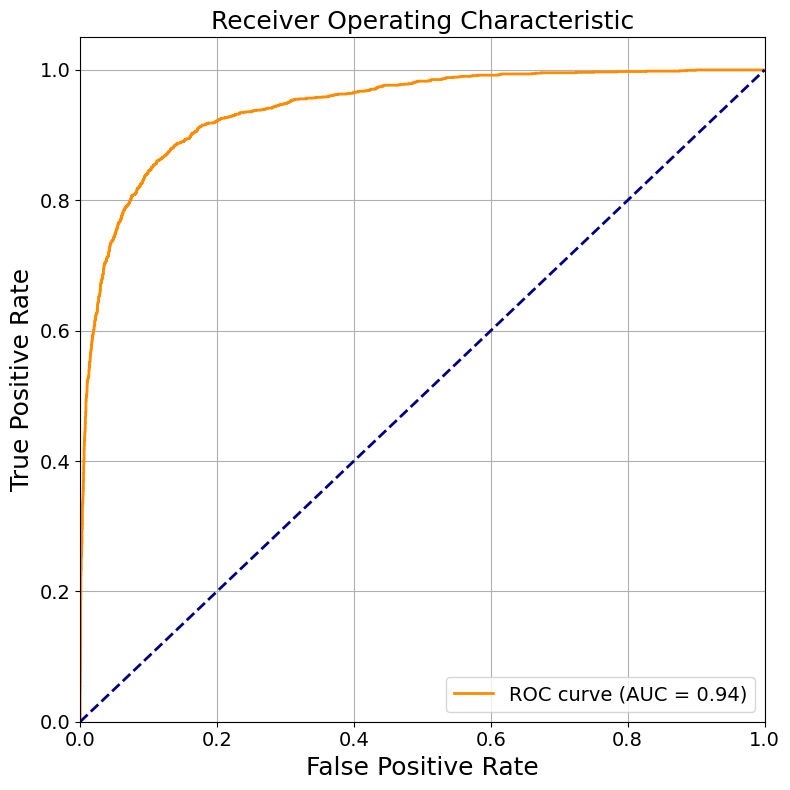

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import json

# Assuming you have predictions and true labels for the test set
y_pred_proba = best_model.predict(x_test)
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred_proba.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver Operating Characteristic', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.grid(True)

# Save the plot as a high-resolution image
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300)

# Save ROC curve data and AUC score to a file
roc_data = {
    'fpr': fpr.tolist(),
    'tpr': tpr.tolist(),
    'auc': roc_auc
}

with open('ColpoSense.json', 'w') as f:
    json.dump(roc_data, f)

# Show the plot
plt.show()